In [5]:
import time
from typing import Any

import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import accuracy_score, classification_report, precision_score, \
    recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC

# Things that belong to strongly predictions, we just remove this
exclusion_list = ['num_outbound_cmds', 'attack_category', 'success_pred', 'attack_type']

# Define nominal and binary columns
# numeric is calculated using above 2.
nominal = ['protocol_type', 'service', 'flag']
binary = ['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login', 'is_guest_login']


def define_numeric_column(data: pd.DataFrame) -> list[Any]:
    # Define numeric columns dynamically based on the dataframe
    return [col for col in data.columns if col not in nominal + binary + exclusion_list]


def print_score():
    # Calculate other evaluation metrics for test set
    precision = precision_score(y_test, y_test_pred, average='weighted')
    recall = recall_score(y_test, y_test_pred, average='weighted')
    f1 = f1_score(y_test, y_test_pred, average='weighted')
    print(f"Naive Bayes CLASSIFIER")
    print("===========================================================================")
    print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
    print("Decision Tree Model Evaluation:")
    print(f"Training Time: {training_time:.4f} seconds")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Testing Accuracy: {test_accuracy:.4f}")
    print(f"Precision (Weighted): {precision:.4f}")
    print(f"Recall (Weighted): {recall:.4f}")
    print(f"F1-Score (Weighted): {f1:.4f}")

    # Print confusion matrix with class labels
    conf_matrix = confusion_matrix(y_test, y_test_pred)
    class_names = np.unique(y)
    print("\nConfusion Matrix with Class Labels:")
    print(pd.DataFrame(conf_matrix, index=class_names, columns=class_names))


def check_fitting():
    print("\nOverfitting/Underfitting Diagnosis:")
    if train_accuracy > test_accuracy + 0.05:  # Arbitrary threshold (e.g., 5% gap)
        print("Possible Overfitting: Training accuracy is significantly higher than testing accuracy.")
    elif train_accuracy < 0.7 and test_accuracy < 0.7:  # Arbitrary low threshold
        print("Possible Underfitting: Both training and testing accuracies are low.")
    else:
        print("Good Fit: Training and testing accuracies are reasonably close.")


def preprocess_data(data: pd.DataFrame) -> tuple:
    data = data.copy()
    # Data cleaning
    data['su_attempted'] = data['su_attempted'].replace({2: 0}, inplace=False)
    # Define columns
    numeric = define_numeric_column(data)
    return data[nominal + numeric + binary], data['attack_category']


def label_encode_nominal_data(features: pd.DataFrame):
    for col in nominal:
        le = LabelEncoder()
        features[col] = le.fit_transform(features[col])


df = pd.read_csv('./data/kdd_merged.csv')
X, y = preprocess_data(df)

label_encode_nominal_data(X)

# Scale numerical features (KNN is distance-based)
numeric_cols = define_numeric_column(df)
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# We didn't require - since the model was reforming quite nicely in terms of training time!
# Feature selection - Select top 20 features
# selector = SelectKBest(score_func=mutual_info_classif, k=20)
# X_train_selected = selector.fit_transform(X_train, y_train)
# X_test_selected = selector.transform(X_test)

# Initialize and train the Decision Tree model
model = GaussianNB()
start_time = time.time()
model.fit(X_train, y_train)
training_time = time.time() - start_time

# Predict on both training and testing sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print_score()
check_fitting()

SIMPLE SVM CLASSIFIER

Classification Report:
               precision    recall  f1-score   support

      benign       0.84      0.02      0.04     15411
         dos       0.49      0.95      0.65     10713
       probe       0.39      0.95      0.55      2816
         r2l       0.21      0.37      0.27       714
         u2r       0.11      0.34      0.17        50

    accuracy                           0.45     29704
   macro avg       0.41      0.53      0.33     29704
weighted avg       0.65      0.45      0.31     29704

Decision Tree Model Evaluation:
Training Time: 0.4522 seconds
Training Accuracy: 0.4552
Testing Accuracy: 0.4550
Precision (Weighted): 0.6513
Recall (Weighted): 0.4550
F1-Score (Weighted): 0.3140

Confusion Matrix with Class Labels:
        benign    dos  probe  r2l  u2r
benign     340  10320   3792  838  121
dos         62  10209    261  180    1
probe        2    129   2682    3    0
r2l          2    240    188  267   17
u2r          1     16     15    1   

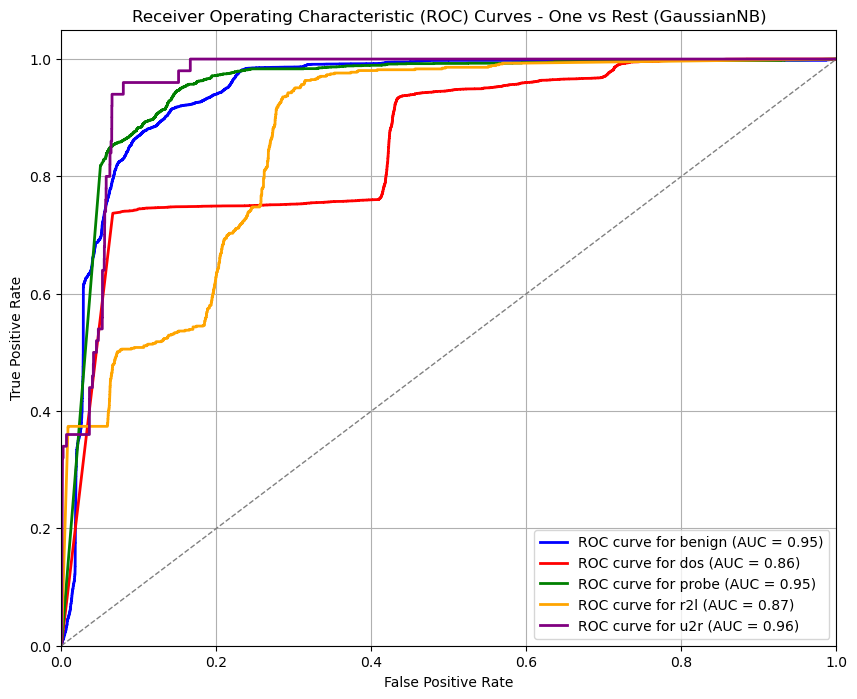


ROC AUC Scores for Each Class:
benign: 0.9455
dos: 0.8559
probe: 0.9508
r2l: 0.8659
u2r: 0.9611


In [6]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


def plot_roc_curve():
    # Get unique classes
    classes = np.unique(y_test)
    n_classes = len(classes)

    # Binarize the test labels
    y_test_bin = label_binarize(y_test, classes=classes)

    # Get predicted probabilities for the test set
    y_test_prob = model.predict_proba(X_test)

    # Compute ROC curve and ROC AUC for each class
    fpr = dict()  # False Positive Rate
    tpr = dict()  # True Positive Rate
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'red', 'green', 'orange', 'purple']  # Adjust based on number of classes
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve for {classes[i]} (AUC = {roc_auc[i]:.2f})')

    # Plot diagonal line (random guessing)
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

    # Customize plot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves - One vs Rest (GaussianNB)')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # Print AUC scores for each class
    print("\nROC AUC Scores for Each Class:")
    for i in range(n_classes):
        print(f"{classes[i]}: {roc_auc[i]:.4f}")

plot_roc_curve()